In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Set global font to Times New Roman (or closest serif available)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman", "Times", "DejaVu Serif"]

In [57]:
mca_df = pd.read_csv('../3_soc_comple/soc_comple.csv')

def determine_risk(row):
    aioe = row['AIOE']
    comple = row['Complementarity']
    #median = 0.5
    median = mca_df['Complementarity'].median()
    
    if aioe < 0:
        if comple < median:
            return 'Isolated'
        else:
            return 'Protected'
    elif comple < median:
        return 'Displaced'
    elif comple > median:
        return 'Augmented'
    
mca_df['Classification'] = mca_df.apply(determine_risk, axis=1)

In [58]:
mca_df['Classification'].value_counts(normalize=True)

Classification
Augmented    0.322328
Displaced    0.268462
Isolated     0.226759
Protected    0.182450
Name: proportion, dtype: float64

# I. How Education Relates to Job Exposure and Augmentability to AI

In [60]:
proportions = mca_df.groupby('Educational Pathway')['Classification'].value_counts(
    normalize=True).reset_index()
pivot_df = proportions.pivot(index='Educational Pathway', columns='Classification', values='proportion')
order = ['Augmented', 'Protected', 'Isolated', 'Displaced']
(pivot_df[order]).round(2)

Classification,Augmented,Protected,Isolated,Displaced
Educational Pathway,,,,
Higher Education,0.46,0.09,0.12,0.34
Not Higher Education,0.08,0.36,0.42,0.15


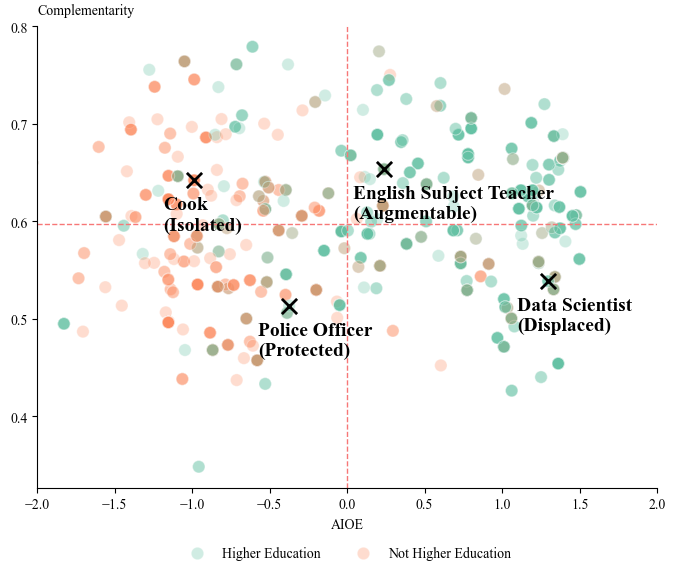

In [61]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=mca_df,
    x='AIOE',
    y='Complementarity',
    hue='Educational Pathway',
    palette='Set2',
    alpha=0.3,
    s=80
)

# Representative jobs (manually chosen)
rep_jobs = {
    "Protected":  {"idx": 822, "title": "Police Officer"},
    "Isolated":  {"idx": 239, "title": "Cook"},
    "Augmentable": {"idx": 349, "title": "English Subject Teacher"},
    "Displaced": {"idx": 283, "title": "Data Scientist"}
}

# Add chosen representative jobs
for c, job in rep_jobs.items():
    row = mca_df.loc[job["idx"]]
    plt.scatter(row['AIOE'], row['Complementarity'],
                marker='x', color='black', s=120, linewidths=2)
    plt.text(row['AIOE']-0.2, row['Complementarity']-0.05,
             f"{job['title']}\n({c})", fontsize=14, color='black',
             fontweight='bold')
    
plt.legend(
    loc="upper center",       # place above or below plot
    bbox_to_anchor=(0.5, -0.1), # shift below the axes
    ncol=2,                   # number of columns
    frameon=False             # remove legend box outline
)

# Axes limits and lines
plt.xlim(-2, 2)
#plt.ylim(-3, 3)
plt.axvline(x=0, color="#f77777", linestyle='--', linewidth=1)
plt.axhline(y=mca_df['Complementarity'].median(), color='#f77777', linestyle='--', linewidth=1)

# Labels
plt.xlabel('AIOE')
plt.ylabel('Complementarity', rotation=0, ha='left')
plt.gca().yaxis.set_label_coords(0, 1.02)

# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Title
#plt.title('AIOE to Complementarity for Filipino Jobs by Educational Pathway\n\n')

plt.savefig('../figures/aioe_comple.png', dpi=300, bbox_inches='tight')

plt.show()

# II. How Sectors Relates to Job Exposure and Augmentability to AI

In [62]:
pivot_df

Classification,Augmented,Displaced,Isolated,Protected
Educational Pathway,,,,
Higher Education,0.457604,0.335128,0.119785,0.087483
Not Higher Education,0.075980,0.147059,0.421569,0.355392


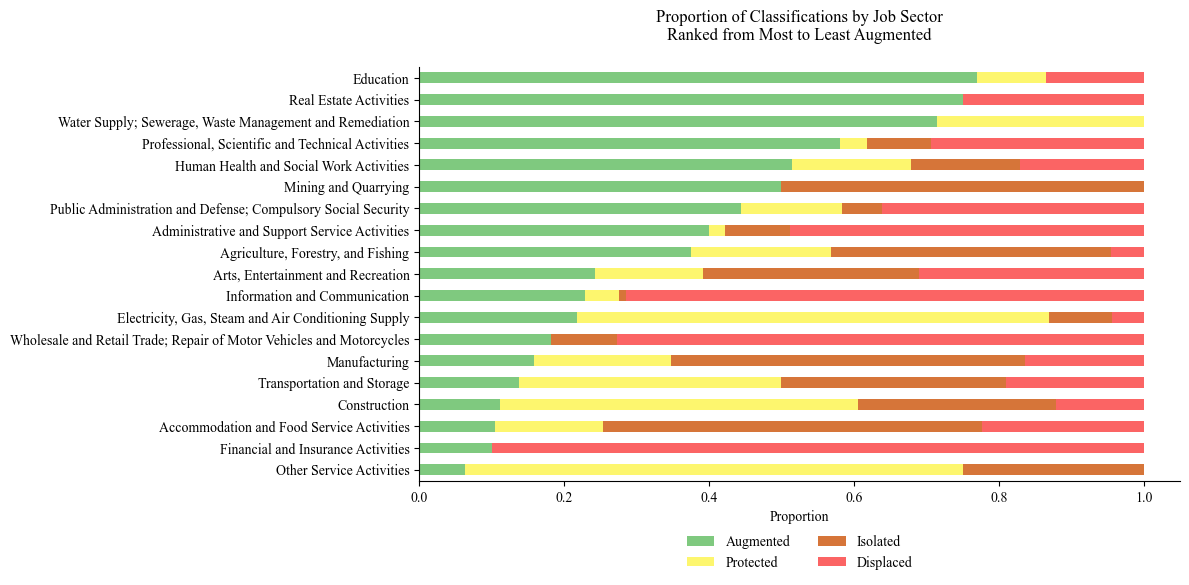

In [65]:
order = ['Augmented', 'Protected', 'Isolated', 'Displaced']

# Get proportions
proportions = mca_df.groupby('Job Sector')['Classification'] \
                    .value_counts(normalize=True) \
                    .reset_index()

# Get the proportions
proportions = mca_df.groupby('Job Sector')['Classification'].value_counts(
    normalize=True).reset_index()
pivot_df = proportions.pivot(index='Job Sector', columns='Classification', values='proportion')

# Make sure the columns are in the desired order
pivot_df = pivot_df[order]
pivot_df.fillna(0, inplace=True)
pivot_df.sort_values(by=['Augmented'], ascending=[True], inplace=True)

# Plot stacked bar chart
pivot_df.plot(kind='barh', 
              stacked=True, 
              figsize=(12,6), 
              color=['#7fc97f', "#fdf66e", "#d67539" , "#fb6464" ],
              #color=["#fdf66e",'#7fc97f',"#fb7164"]
              )

# pretty graph pls
plt.xlabel('Proportion')
plt.ylabel('')
plt.title('Proportion of Classifications by Job Sector\nRanked from Most to Least Augmented\n')
plt.legend(
    loc="upper center",       # place above or below plot
    bbox_to_anchor=(0.5, -0.1), # shift below the axes
    ncol=2,                   # number of columns
    frameon=False             # remove legend box outline
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

We will now develop a metric to summarize the risk of replacement at the occupation level to AI. This is called the C-AIOE, formally defined as:
$$\text{C-AIOE}_i = \text{AIOE}_i \cdot (1 - (\theta_i - \theta_{\text{MIN}})),$$

where $i$ indexes the job, $\theta_i$ is complementarity to AI, and $\theta_{\text{MIN}}$ is minimum value of $\theta_i$ across all occupations. Overall, jobs with higher C-AIOE because of higher AIOE or lower complementarity are more likely to face AI replacement. 

In [66]:
min_comple = mca_df['Complementarity'].min()
factor = 1 - (mca_df['Complementarity'] - min_comple)
mca_df['C-AIOE'] = mca_df['AIOE'] * factor

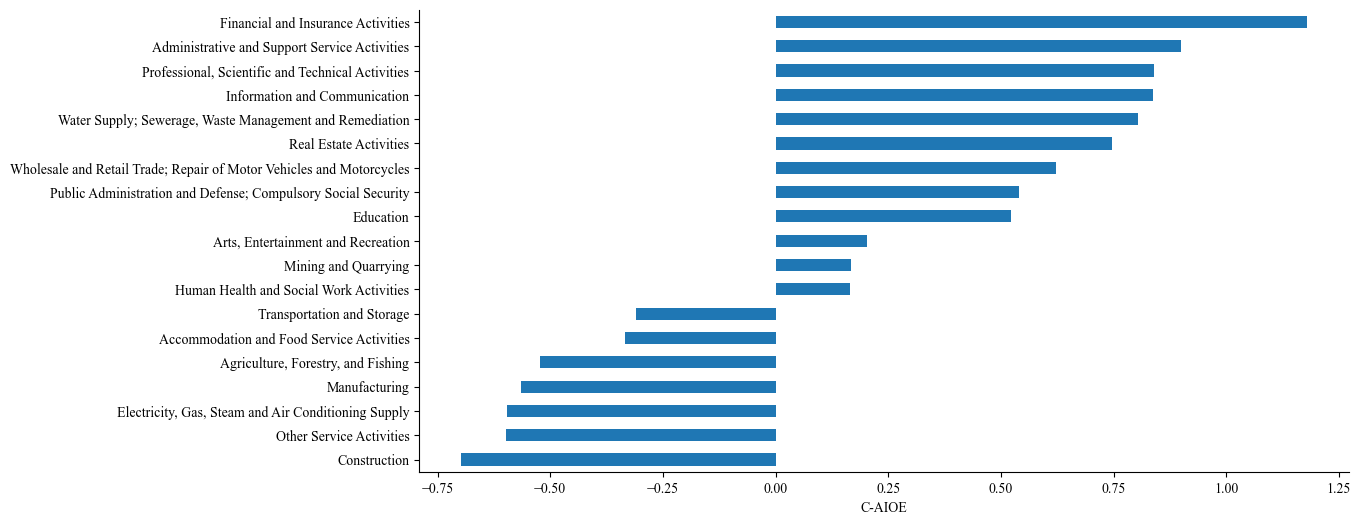

In [67]:
plt.figure(figsize=(12, 6))
mca_df.groupby('Job Sector')['C-AIOE'].median().sort_values().plot(kind='barh')

# pretty graph pls
plt.xlabel('C-AIOE')
plt.ylabel('')
#plt.title('Job Sectors Ranked Most Likely\nAutomated by AI (Based on C-AIOE)\n')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('../figures/sector_caioe.png', dpi=300, bbox_inches='tight')

plt.show()


In [69]:
mca_df.to_csv('../final_mca_aioe_comple.csv')